In [1]:
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
from pandas import DataFrame

from non_parametric_deconvolution import modelfree_deconv

%matplotlib notebook

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
# load data
img = nib.load('sample_data/4d_dce_image.nii.gz')
im = np.squeeze(img.get_data())
mask_aif = nib.load('sample_data/aif.nii.gz')
ma_aif = mask_aif.get_data()

dt = 1130 # time between frames in milliseconds

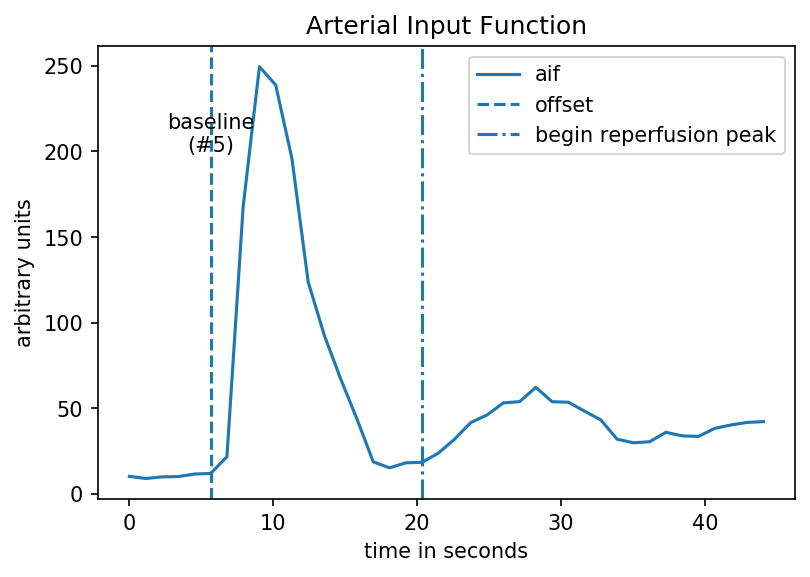

In [4]:
# calculate aif
aif = np.mean(im[ma_aif != 0], axis=0)
timesteps = np.arange(len(aif), dtype=np.float32) * dt / 1000

plt.title('Arterial Input Function')
plt.plot(timesteps, aif, label='aif')
plt.xlabel('time in seconds')
plt.ylabel('arbitrary units')
plt.axvline(dt / 1000 * 5, label='offset', linestyle='--')
plt.text(dt / 1000 * 5, 200, 'baseline\n(#5)', horizontalalignment='center')
plt.axvline(dt / 1000 * 18, label='begin reperfusion peak', linestyle='-.')
plt.legend()

In [5]:
# calculate perfusion, mean transit time, and blood volume maps
r = modelfree_deconv(im, aif, dt, n_offset=5)
perf, mtt, bv = r['flow'], r['mtt'], r['volume']

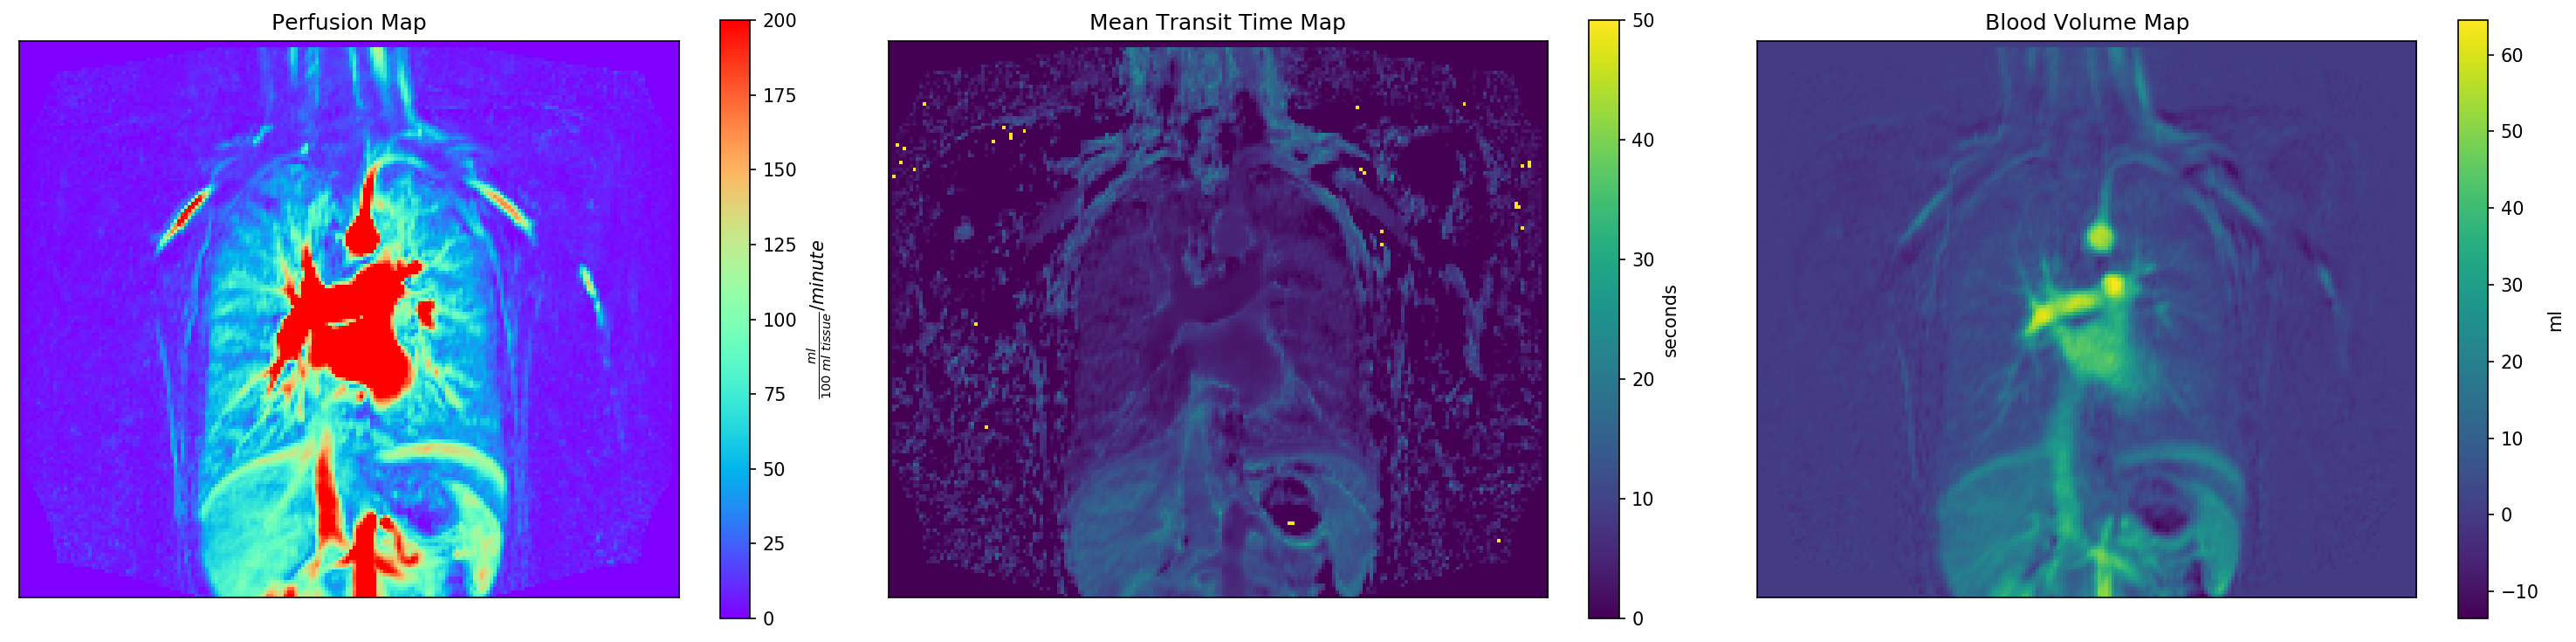

In [6]:
# plot perfusion, mean transit time, and blood volume maps
slice_id = 15
fig, axs = plt.subplots(ncols=3, figsize=(20,5))

axs[0].set_title('Perfusion Map')
dist = axs[0].imshow(perf[..., slice_id].T, vmin=0, vmax=200, cmap='rainbow')
cbar = fig.colorbar(dist, ax=axs[0])
cbar.set_label(r'$\frac{ml}{100~ml~tissue}/minute$')

axs[1].set_title('Mean Transit Time Map')
dist = axs[1].imshow(mtt[..., slice_id].T, vmin=0, vmax=50)
cbar = fig.colorbar(dist, ax=axs[1])
cbar.set_label('seconds')

axs[2].set_title('Blood Volume Map')
dist = axs[2].imshow(bv[..., slice_id].T)
cbar = fig.colorbar(dist, ax=axs[2])
cbar.set_label('ml')

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout(h_pad=1)

In [7]:
# save perfusion, mean transit time, and blood volume maps as Nifti
# please note, that mtt needs to be clipped due to extreme values
nib.Nifti1Image(perf, img.affine).to_filename('sample_data/perfusion_map.nii.gz')
nib.Nifti1Image(np.clip(mtt, 0, 50), img.affine).to_filename('sample_data/mtt_map.nii.gz')
nib.Nifti1Image(bv, img.affine).to_filename('sample_data/bv_map.nii.gz')

In [8]:
# lobe based evaluation of potential biomarkers

# the lobe based segmentation has been performed by a neural network, as described in the paper
mask_lobes = nib.load('sample_data/lobe_segmentation.nii.gz')
ma_lobes = mask_lobes.get_data()

lookup_table = {'rul': 1, # right upper lobe
                'ml':  2, # middle lobe
                'rll': 3, # right lower lobe
                'lul': 4, # left upper lobe
                'lll': 5} # left lower lobe

statistical_tests = {'median': np.median,
                     'mean':   np.mean,
                     'std':    np.std}

maps = {'perfusion': perf,
        'mtt':       mtt,
        'bv':        bv}

df = DataFrame()
for lobe, lobe_id in lookup_table.items():
    vals = {'lobe': lobe}
    mask = ma_lobes == lobe_id
    for function_name, function in statistical_tests.items():
        for map_name, map_val in maps.items():
            vals['%s %s' % (map_name, function_name)] = function(map_val[mask])
    df = df.append(vals, ignore_index=True)

keys = [x for x in df.keys()]
keys.remove('lobe')
keys.insert(0, 'lobe')
df[keys]

,lobe,bv mean,bv median,bv std,mtt mean,mtt median,mtt std,perfusion mean,perfusion median,perfusion std
0,rul,4.629634,4.096138,3.789851,6.345179,4.103909,150.589772,62.648200,56.040921,36.189910
1,ml,4.360482,3.842423,3.262085,-3.255758,5.590194,683.907322,44.482688,37.847668,33.118090
2,rll,9.059761,7.584128,6.185036,5.295984,4.355007,4.373568,114.958864,99.997777,85.770043
3,lul,4.041536,3.635069,3.361209,3.859962,3.869109,4.679359,61.310114,52.981353,42.261399
4,lll,8.360019,7.670687,5.512245,7.975408,4.628290,377.262848,107.077833,92.983795,75.804532
